In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr)
library(dplyr); library(tidyr)
library(ggplot2)
library(rwantshue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
library(biom)

In [4]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [5]:
%%R
biom = read_biom("../../SeqData/Funguilds/ITS.otu_table.meta.biom")
biom = observation_metadata(biom)
head(biom)

        trophic.mode confidence taxon.level                guild       taxon
OTU_4     Saprotroph   Probable          13 Undefined Saprotroph Penicillium
OTU_568            -          -           -                    -           -
OTU_5              -          -           -                    -           -
OTU_9              -          -           -                    -           -
OTU_3     Saprotroph   Probable          13 Undefined Saprotroph    Emmonsia
OTU_64             -          -           -                    -           -


In [6]:
%%R
biom$OTU = rownames(biom)
head(biom)

        trophic.mode confidence taxon.level                guild       taxon
OTU_4     Saprotroph   Probable          13 Undefined Saprotroph Penicillium
OTU_568            -          -           -                    -           -
OTU_5              -          -           -                    -           -
OTU_9              -          -           -                    -           -
OTU_3     Saprotroph   Probable          13 Undefined Saprotroph    Emmonsia
OTU_64             -          -           -                    -           -
            OTU
OTU_4     OTU_4
OTU_568 OTU_568
OTU_5     OTU_5
OTU_9     OTU_9
OTU_3     OTU_3
OTU_64   OTU_64


In [7]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [8]:
%%R
mdf = psmelt(physeq)

In [9]:
%%R
# Add FunGuild observation metadata
mdf = merge(mdf,biom, by = "OTU")

In [132]:
%%R
head(mdf)

    OTU   Sample Abundance Cosm Month        Trtmt Kingdom     Phylum
1 OTU_1 S_2.5_13        13   13   2.5         Soil   Fungi Ascomycota
2 OTU_1 S_2.5_27       232   27   2.5         Soil   Fungi Ascomycota
3 OTU_1  F_2.5_3        13    3   2.5 Ferrihydrite   Fungi Ascomycota
4 OTU_1   S_2_33     35197   33   2.0         Soil   Fungi Ascomycota
5 OTU_1   F_3_20       428   20   3.0 Ferrihydrite   Fungi Ascomycota
6 OTU_1  K_2.5_3         2    3   2.5    Kaolinite   Fungi Ascomycota
            Class       Order            Family     Genus      Species Rank1
1 Sordariomycetes Sordariales Lasiosphaeriaceae Podospora Podospora sp  <NA>
2 Sordariomycetes Sordariales Lasiosphaeriaceae Podospora Podospora sp  <NA>
3 Sordariomycetes Sordariales Lasiosphaeriaceae Podospora Podospora sp  <NA>
4 Sordariomycetes Sordariales Lasiosphaeriaceae Podospora Podospora sp  <NA>
5 Sordariomycetes Sordariales Lasiosphaeriaceae Podospora Podospora sp  <NA>
6 Sordariomycetes Sordariales Lasiosphaeriaceae 

In [148]:
%%R
levels(as.factor(mdf$confidence))

[1] "-"               "Highly Probable" "Possible"        "Probable"       


###Phylogenetic overview

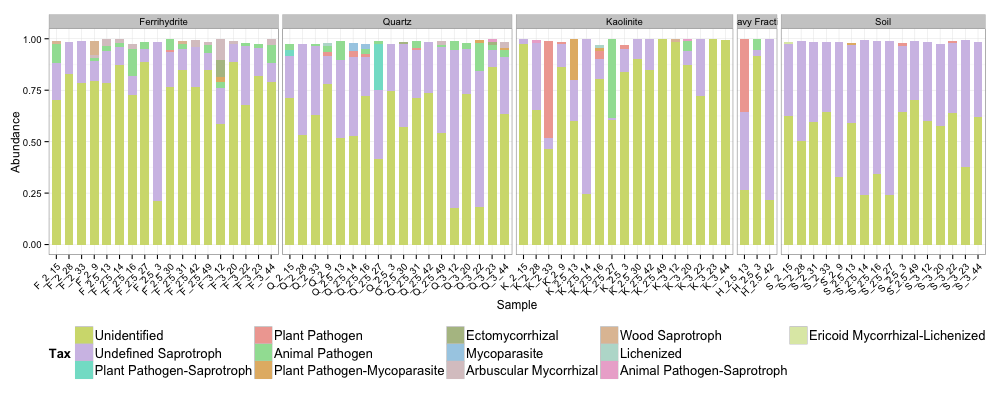

In [157]:
%%R -w 1000 -h 400

cutoff = 0.01
totabund = 1
confidence = c("Highly Probable","Probable")

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$guild = ifelse(d.plot$confidence %in% confidence, d.plot$guild, "Unidentified")
d.plot = d.plot %>%
    group_by(Sample, guild, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
#    filter(Month == 2.5) %>%
#    filter(Trtmt != "Kaolinite") %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    axis.text.x = element_text(angle=45, hjust=1), 
    legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p

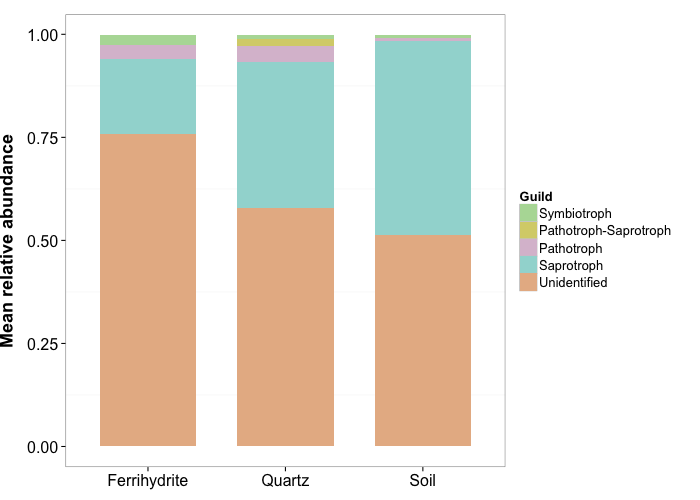

In [156]:
%%R -w 700 -h 500

cutoff = 0.005
totabund = 3000
confidence =  c("Highly Probable","Probable")

d.plot = mdf %>%
    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$trophic.mode = ifelse(d.plot$confidence %in% confidence, d.plot$trophic.mode, "Unidentified")
d.plot$trophic.mode = ifelse(is.na(d.plot$trophic.mode)==TRUE, "Unidentified", paste(d.plot$trophic.mode))
d.plot = d.plot %>%
    group_by(Trtmt,Month, trophic.mode, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, trophic.mode) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,trophic.mode)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))
#d.plot$Month = as.factor(d.plot$Month)
#d.plot$Month=ifelse(d.plot$Month==2.0,"1 Month", ifelse(d.plot$Month==2.5,"1.5 Months","2 Months"))


d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]
#d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(title="Guild",ncol = 1, reverse=TRUE))

p = p + theme_bw()

p = p + ylab("Mean relative abundance")

p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=16), 
    axis.title.y = element_text(size=18, face="bold", vjust=2),
    legend.position="right", legend.text=element_text(size=13), legend.title=element_text(size=13),
    panel.grid.major= element_blank())
p

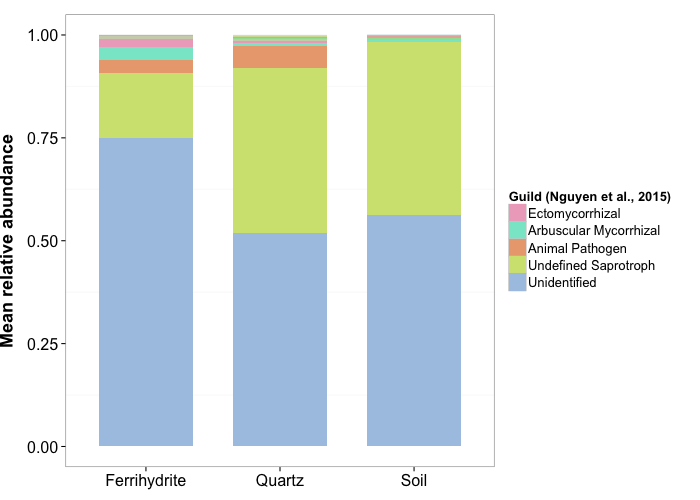

In [10]:
%%R -w 700 -h 500

cutoff = 0.00
totabund = 2000
confidence =  c("Highly Probable"
                ,"Probable"
                #,"Possible"
               )

d.plot = mdf %>%
    filter(Month == 3) %>%
    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$guild = ifelse(d.plot$confidence %in% confidence, d.plot$guild, "Unidentified")
d.plot$guild = ifelse(is.na(d.plot$guild)==TRUE, "Unidentified", paste(d.plot$guild))
d.plot$guild = ifelse(d.plot$guild=="-", "Unidentified", paste(d.plot$guild))
d.plot$guild = ifelse(d.plot$guild=="unidentified", "Unidentified", paste(d.plot$guild))
d.plot = d.plot %>%
    group_by(Trtmt,Month, guild, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, guild) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,guild)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))
#d.plot$Month = as.factor(d.plot$Month)
#d.plot$Month=ifelse(d.plot$Month==2.0,"1 Month", ifelse(d.plot$Month==2.5,"1.5 Months","2 Months"))


d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]
#d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

N=5
Guilds=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors, breaks=Guilds)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(title="Guild (Nguyen et al., 2015)",ncol = 1, reverse=TRUE))

p = p + theme_bw()

p = p + ylab("Mean relative abundance")

p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=16), 
    axis.title.y = element_text(size=18, face="bold", vjust=2),
    legend.position="right", legend.text=element_text(size=13), legend.title=element_text(size=13),
    panel.grid.major= element_blank())
p

In [225]:
%%R
ggsave(filename="RelabundFunguild.jpg", p, width=8, height=6)

In [172]:
%%R
unique(mdf[mdf$guild=="Animal Pathogen",c(1,7:14)])
# List of OTUs identified as animal pathogens

            OTU Kingdom        Phylum           Class             Order
26500  OTU_1330   Fungi    Ascomycota Sordariomycetes       Hypocreales
38180  OTU_1476   Fungi    Ascomycota Sordariomycetes       Hypocreales
40662  OTU_1506   Fungi    Ascomycota Sordariomycetes       Hypocreales
45115  OTU_1565   Fungi    Ascomycota Sordariomycetes       Hypocreales
58547  OTU_1732   Fungi    Ascomycota Saccharomycetes Saccharomycetales
66869  OTU_1838   Fungi    Ascomycota Sordariomycetes       Hypocreales
69643  OTU_1872   Fungi    Ascomycota Saccharomycetes Saccharomycetales
74242  OTU_1930   Fungi    Ascomycota Sordariomycetes       Hypocreales
87455  OTU_2097   Fungi    Ascomycota Sordariomycetes       Hypocreales
92857  OTU_2166   Fungi    Ascomycota Sordariomycetes       Hypocreales
98113  OTU_2231   Fungi    Ascomycota Sordariomycetes       Hypocreales
100011  OTU_244   Fungi    Ascomycota Sordariomycetes       Hypocreales
102858   OTU_28   Fungi    Ascomycota Sordariomycetes       Hypo

In [226]:
%%R
d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    filter(guild=="Animal Pathogen")%>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    filter(sum(Abundance)>0)
d.plot$Species = ifelse(is.na(d.plot$Species)==TRUE, paste(d.plot$Genus), paste(d.plot$Species))
d.plot = d.plot %>%
    mutate(abund.insample = Abundance / sum(Abundance))%>%
    group_by(OTU,Trtmt,Species) %>%
    summarize(mean.relabund = mean(abund.insample))%>%
    group_by(Trtmt,Species) %>%
    summarize(relabund=sum(mean.relabund))
d.plot[21:40,]

Source: local data frame [20 x 3]
Groups: Trtmt

    Trtmt                   Species    relabund
1  Quartz             Lecanicillium 0.011572802
2  Quartz  Lecanicillium fusisporum 0.013871246
3  Quartz      Malassezia restricta 0.021347455
4  Quartz               Metarhizium 0.004569156
5  Quartz                  Pochonia 0.872031023
6  Quartz             Simplicillium 0.000000000
7  Quartz Tolypocladium parasiticum 0.001016703
8  Quartz     Trichosporon cutaneum 0.000000000
9    Soil                 Beauveria 0.060603448
10   Soil          Candida albicans 0.008888889
11   Soil        Candida catenulata 0.000000000
12   Soil     Clavispora lusitaniae 0.000000000
13   Soil                 Cordyceps 0.028984674
14   Soil      Haptocillium sinense 0.001839080
15   Soil             Lecanicillium 0.000000000
16   Soil  Lecanicillium fusisporum 0.000000000
17   Soil      Malassezia restricta 0.136719577
18   Soil               Metarhizium 0.022222222
19   Soil                  Pochonia 0.7

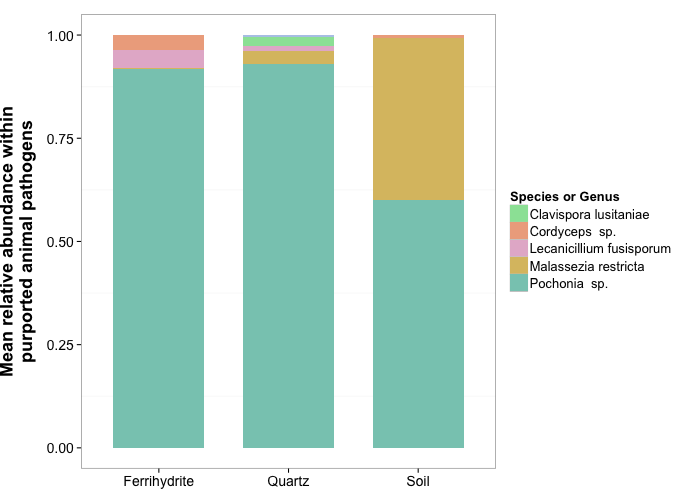

In [210]:
%%R -w 700 -h 500

totabund = 1000

d.plot = mdf %>%
    filter(Month==3)%>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    filter(guild=="Animal Pathogen")%>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    filter(sum(Abundance)>0)
d.plot$Species = ifelse(is.na(d.plot$Species)==TRUE, paste(d.plot$Genus," sp."), paste(d.plot$Species))
d.plot = d.plot %>%
    mutate(abund.insample = Abundance / sum(Abundance))%>%
    group_by(OTU,Trtmt,Species) %>%
    summarize(mean.relabund = mean(abund.insample))%>%
    group_by(Trtmt,Species) %>%
    summarize(relabund=sum(mean.relabund))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
lev = mean.Abund[order(-mean.Abund$M),]$Tax
d.plot$Tax = factor(d.plot$Tax, levels=lev)

#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

N=5
Species=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]

p = p + scale_fill_manual(values = colors, breaks=Species)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(title = "Species or Genus", ncol = 1, reverse=TRUE))

p = p + theme_bw() + labs(y="Mean relative abundance within\npurported animal pathogens")
p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=14), 
    axis.title.y = element_text(size=18, face="bold", vjust=2),
    legend.position="right", legend.text=element_text(size=13), legend.title=element_text(size=13),
    panel.grid.major= element_blank())

p

###Looking at Glomeromycota only

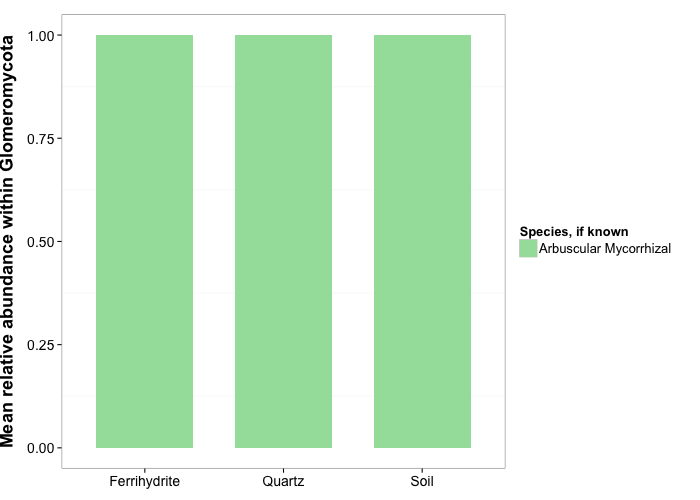

In [146]:
%%R -w 700 -h 500

totabund = 2000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    filter(Phylum=="Glomeromycota")%>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    filter(sum(Abundance)>0)
d.plot$guild = ifelse(is.na(d.plot$guild)==TRUE, d.plot$OTU, paste(d.plot$guild))
d.plot = d.plot %>%
    mutate(abund.insample = Abundance / sum(Abundance))%>%
    group_by(OTU,Trtmt,guild) %>%
    summarize(mean.relabund = mean(abund.insample))%>%
    group_by(Trtmt,guild) %>%
    summarize(relabund=sum(mean.relabund))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

d.plot$Tax = factor(d.plot$Tax, levels=lev)
# Order the Phyla by abundance
#.plot$Month = factor(d.plot$Month)
#d.plot$Month=ifelse(d.plot$Month==2.0,"1 Month", ifelse(d.plot$Month==2.5,"1.5 Months","2 Months"))

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Trtmt, Tax)),]
#d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

N=12
Species=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
Species = Species[grepl("OTU",paste(Species))==FALSE]

p = p + scale_fill_manual(values = colors, breaks=Species)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(title = "Species, if known", ncol = 1, reverse=TRUE))

p = p + theme_bw() + labs(y="Mean relative abundance within Glomeromycota")
p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=14), 
    axis.title.y = element_text(size=18, face="bold", vjust=2),
    legend.position="right", legend.text=element_text(size=13), legend.title=element_text(size=13),
    panel.grid.major= element_blank())

p

##Total abundance of known guilds

In [244]:
%%R

conf = c("Highly Probable"
        # ,"Probable"
        # , "Possible"
        )

ps2 = mdf %>%
    filter(confidence %in% conf)%>%
    filter(Trtmt!="Blank" & Trtmt!="Kaolinite" & Trtmt!="Heavy Fraction")%>%
    group_by(Trtmt,Month,OTU)%>%
    filter(sum(Abundance)>0)%>%
    group_by(Trtmt,guild) %>%
    summarize(n=n_distinct(OTU))

guilds = c("Ectomycorrhizal", "Ectomycorrhizal-Saprotroph", "Arbuscular Mycorrhizal")
ps2[ps2$guild %in% guilds,]

Source: local data frame [6 x 3]
Groups: Trtmt

         Trtmt                  guild  n
1 Ferrihydrite Arbuscular Mycorrhizal 44
2 Ferrihydrite        Ectomycorrhizal  4
3       Quartz Arbuscular Mycorrhizal 29
4       Quartz        Ectomycorrhizal  3
5         Soil Arbuscular Mycorrhizal 44
6         Soil        Ectomycorrhizal  3


In [246]:
%%R

conf = c("Highly Probable"
        # ,"Probable"
        # , "Possible"
        )

ps3 = mdf %>%
    filter(Trtmt!="Blank" & Trtmt!="Kaolinite" & Trtmt!="Heavy Fraction")%>%
    group_by(Sample)%>%
    mutate(relabund=Abundance/sum(Abundance))%>%
    group_by(Sample,Trtmt,confidence,guild)%>%
    summarize(relabund=sum(relabund))%>%
    group_by(Trtmt,guild)%>%
    filter(confidence %in% conf)%>%
    summarize(relabund=mean(relabund))

guilds = c("Ectomycorrhizal", "Ectomycorrhizal-Saprotroph", "Arbuscular Mycorrhizal")
ps3[ps3$guild %in% guilds,]

Source: local data frame [6 x 3]
Groups: Trtmt

         Trtmt                  guild     relabund
1 Ferrihydrite Arbuscular Mycorrhizal 1.735825e-02
2 Ferrihydrite        Ectomycorrhizal 5.102433e-03
3       Quartz Arbuscular Mycorrhizal 5.181039e-03
4       Quartz        Ectomycorrhizal 1.984169e-03
5         Soil Arbuscular Mycorrhizal 3.161485e-03
6         Soil        Ectomycorrhizal 5.449234e-05
